## Exploring Global Fishing Watch Public Data

### Setup

In [2]:
#!pip install mapclassify contextily

In [3]:
from sedona.spark import *
from pyspark.sql.functions import expr, col
import geopandas
import contextily as cx

In [4]:
config = SedonaContext.builder().getOrCreate()
sedona = SedonaContext.create(config)

24/01/18 15:24:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/18 15:24:03 WARN Utils: Service 'sparkDriver' could not bind on port 7070. Attempting port 7071.
24/01/18 15:24:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/01/18 15:24:05 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
24/01/18 15:24:05 WARN S3ABlockOutputStream: Application invoked the Syncable API against stream writing to qjnq6fcbf1/spark-logs/spark-6225243403c94e76a8a8995a77e2c19b.inprogress. This is unsupported
24/01/18 15:24:30 WARN SedonaContext: Python files are not set. Sedona will not pre-load Python UDFs.


In [5]:
S3_URL_VESSELS = "s3://wbts-wbc-m97rcg45xi/qjnq6fcbf1/data/customer-hd1rff9kg390pk/globalfishwatch/industrial_vessels_v20231013.csv"
S3_URL_INFRASTRUCTURE = "s3://wbts-wbc-m97rcg45xi/qjnq6fcbf1/data/customer-hd1rff9kg390pk/globalfishwatch/offshore_infrastructure_v20231106.csv"
S3_URL_DATA_ROOT = "s3://wbts-wbc-m97rcg45xi/qjnq6fcbf1/data/customer-hd1rff9kg390pk/geoparquet/"

## Offshore Infrastructure

In [11]:
offshore_infra_df = sedona.read.format('csv'). \
    option('header','true').option('delimiter', ','). \
    load(S3_URL_INFRASTRUCTURE)

offshore_infra_df.show(5)

+------------+--------------+--------------+----------------+-----------------+
|structure_id|composite_date|         label|             lat|              lon|
+------------+--------------+--------------+----------------+-----------------+
|      115958|    2019-09-01|lake_maracaibo|9.71025137100954|-71.0518565233426|
|      115958|    2018-12-01|lake_maracaibo|9.71025137100954|-71.0518565233426|
|      115958|    2019-07-01|lake_maracaibo|9.71025137100954|-71.0518565233426|
|      115958|    2018-06-01|lake_maracaibo|9.71025137100954|-71.0518565233426|
|      115958|    2020-08-01|lake_maracaibo|9.71025137100954|-71.0518565233426|
+------------+--------------+--------------+----------------+-----------------+
only showing top 5 rows



In [12]:
offshore_infra_df.count()

1441242

In [13]:
offshore_infra_df = offshore_infra_df.selectExpr(
    'ST_POINT(CAST(lon AS float), CAST(lat AS float)) AS location',
    'structure_id',
    'label',
    'CAST(composite_date AS date) AS composite_date'
)
offshore_infra_df.createOrReplaceTempView("infrastructure")
offshore_infra_df.show(5)

+--------------------+------------+--------------+--------------+
|            location|structure_id|         label|composite_date|
+--------------------+------------+--------------+--------------+
|POINT (-71.051856...|      115958|lake_maracaibo|    2019-09-01|
|POINT (-71.051856...|      115958|lake_maracaibo|    2018-12-01|
|POINT (-71.051856...|      115958|lake_maracaibo|    2019-07-01|
|POINT (-71.051856...|      115958|lake_maracaibo|    2018-06-01|
|POINT (-71.051856...|      115958|lake_maracaibo|    2020-08-01|
+--------------------+------------+--------------+--------------+
only showing top 5 rows



In [14]:
sedona.sql("SELECT COUNT(*) AS num, label FROM infrastructure GROUP BY label").show()

+------+--------------+
|   num|         label|
+------+--------------+
|518138|           oil|
| 42358|  possible_oil|
|  8169| probable_wind|
|  1082| possible_wind|
| 23101|  probable_oil|
|288390|lake_maracaibo|
|436659|          wind|
|123345|       unknown|
+------+--------------+



In [15]:
sedona.sql("""
    WITH distinct_ids AS (SELECT DISTINCT(structure_id) FROM infrastructure) 
    SELECT COUNT(*) FROM distinct_ids
""").show()

+--------+
|count(1)|
+--------+
|   39979|
+--------+



In [17]:
distinct_infra_df = sedona.sql("""
    WITH grouped AS (
        SELECT structure_id, location, 
            CASE WHEN label IN ("possible_oil", "probable_oil", "oil") THEN 'oil' 
                WHEN label IN ("possible_wind", "probably_wind", "wind") THEN "wind" 
                WHEN label IN ("unknown") THEN "unknown" 
                ELSE 'other' END AS label FROM infrastructure)
    SELECT any_value(location) AS location, any_value(label) AS label, structure_id FROM grouped
    GROUP BY structure_id
""")

distinct_infra_df.show(truncate=False)

+-----------------------------------------------+-------+------------+
|location                                       |label  |structure_id|
+-----------------------------------------------+-------+------------+
|POINT (103.75604248046875 1.1634979248046875)  |unknown|100010      |
|POINT (-89.39741516113281 29.526275634765625)  |oil    |100020      |
|POINT (-62.434349060058594 -40.389244079589844)|unknown|10009       |
|POINT (-93.38289642333984 29.621318817138672)  |oil    |10011       |
|POINT (121.53759765625 32.28779220581055)      |unknown|100133      |
|POINT (2.0189096927642822 59.546932220458984)  |oil    |100296      |
|POINT (48.931785583496094 28.420513153076172)  |oil    |100467      |
|POINT (56.71395492553711 18.25113868713379)    |oil    |100469      |
|POINT (121.84056854248047 32.76438903808594)   |wind   |100504      |
|POINT (7.764649868011475 55.0511589050293)     |wind   |100509      |
|POINT (48.97321319580078 28.50174903869629)    |oil    |100523      |
|POINT

In [18]:
SedonaKepler.create_map(distinct_infra_df, name="Offshore Infrastructure")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Offshore Infrastructure': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

## Industrial Vessels

In [20]:
industrial_vessel_df = sedona.read.format('csv'). \
    option('header','true'). \
    option('delimiter', ','). \
    load(S3_URL_VESSELS)

industrial_vessel_df.show(5)

+--------------------+--------------------+--------------------+-------------------+------------------+---------+------------------+--------------------+-------------------+------------------+--------------------+
|           timestamp|           detect_id|            scene_id|                lat|               lon|     mmsi|          length_m|      matching_score|      fishing_score|  matched_category|overpasses_2017_2021|
+--------------------+--------------------+--------------------+-------------------+------------------+---------+------------------+--------------------+-------------------+------------------+--------------------+
|2024-01-04T08:43:45Z|S1B_IW_GRDH_1SDV_...|S1B_IW_GRDH_1SDV_...| 22.979166296784371|37.319151929419519|373297000|146.42368000000002|  0.1725925478995845|           0.012883|matched_nonfishing|                  34|
|2024-01-04T08:43:45Z|S1A_IW_GRDH_1SDV_...|S1A_IW_GRDH_1SDV_...| 22.966207343473862|37.219209175404536|636016933|123.42801999999999|0.0053388812

In [21]:
industrial_vessel_df.count()

23088625

In [22]:
industrial_vessel_df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- detect_id: string (nullable = true)
 |-- scene_id: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- mmsi: string (nullable = true)
 |-- length_m: string (nullable = true)
 |-- matching_score: string (nullable = true)
 |-- fishing_score: string (nullable = true)
 |-- matched_category: string (nullable = true)
 |-- overpasses_2017_2021: string (nullable = true)



In [23]:
industrial_vessel_df = industrial_vessel_df.selectExpr(
    'ST_Point(CAST(lon AS Decimal(24,20)), CAST(lat AS Decimal(24,20))) AS location', 
    'CAST(timestamp AS Timestamp) AS timestamp', 
    'detect_id', 
    'scene_id', 
    'mmsi', 
    'CAST(length_m AS float) AS length_m', 
    'CAST(matching_score AS float) AS matching_score', 
    'CAST(fishing_score AS float) AS fishing_score', 
    'matched_category', 
    'CAST(overpasses_2017_2021 AS integer) AS overpasses_2017_2021')
industrial_vessel_df.createOrReplaceTempView('iv')

In [24]:
industrial_vessel_df.printSchema()

root
 |-- location: geometry (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- detect_id: string (nullable = true)
 |-- scene_id: string (nullable = true)
 |-- mmsi: string (nullable = true)
 |-- length_m: float (nullable = true)
 |-- matching_score: float (nullable = true)
 |-- fishing_score: float (nullable = true)
 |-- matched_category: string (nullable = true)
 |-- overpasses_2017_2021: integer (nullable = true)



In [25]:
sedona.sql("""
SELECT COUNT(*), matched_category 
FROM iv
GROUP BY matched_category
""").show()

+--------+------------------+
|count(1)|  matched_category|
+--------+------------------+
| 2864709|   matched_fishing|
|  803624|   matched_unknown|
| 9187828|         unmatched|
|10232464|matched_nonfishing|
+--------+------------------+



In [26]:
sedona.sql("""
WITH distinct_ids AS (SELECT DISTINCT(mmsi) FROM iv) 
SELECT COUNT(*) FROM distinct_ids
""").show()

+--------+
|count(1)|
+--------+
|  517374|
+--------+



In [27]:
h3_industrial_df = sedona.sql("""
WITH h3vals AS (SELECT 
    COUNT(*) AS num, 
    ST_H3ToGeom(ST_H3CellIDs(location, 2, false)) as geometry, 
    ST_H3CellIDs(location, 2, false) as h3 
FROM iv
GROUP BY h3)
SELECT *, CAST(h3[0] as string) AS h3cell FROM h3vals
""")

h3_industrial_df = h3_industrial_df.filter(~col('h3cell').isin(['585707645093019647','588201337464815615','588199688197373951', '588758240104284159', '588759889371725823', '588742846941495295']))


In [28]:
SedonaKepler.create_map(h3_industrial_df, name="Industrial Vessels" )

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Industrial Vessels': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, …

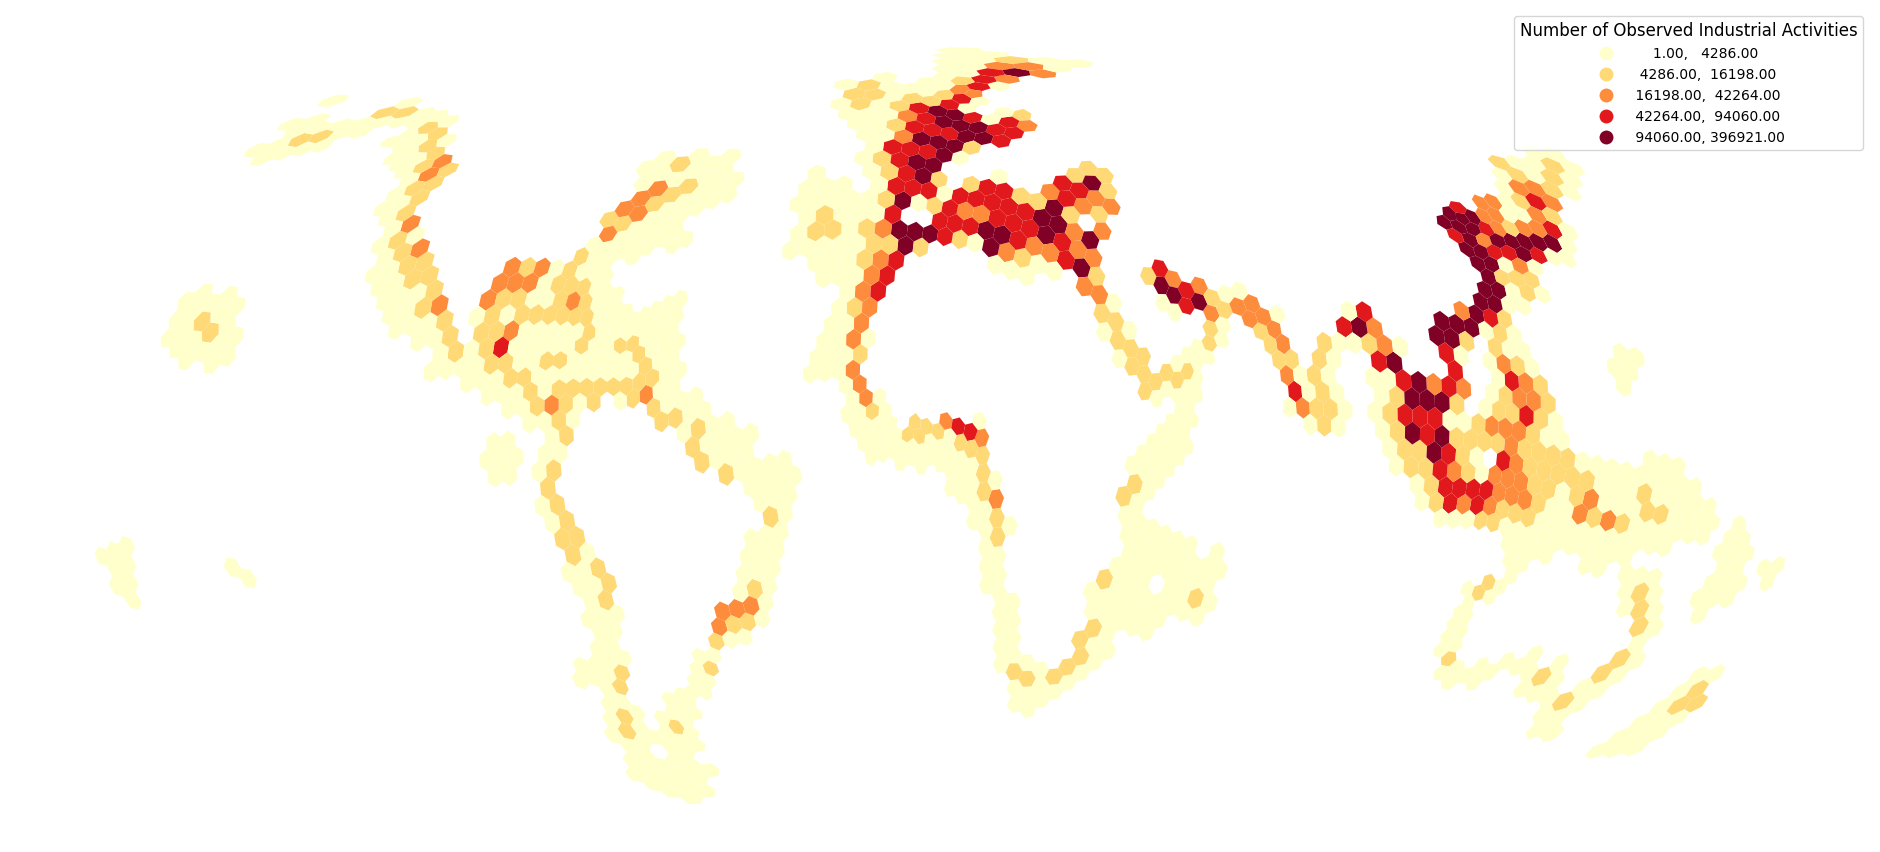

In [29]:
h3_gdf = geopandas.GeoDataFrame(h3_industrial_df.toPandas(), geometry='geometry', crs="4326")

h3_gdf = h3_gdf.to_crs(epsg=8857)

ax = h3_gdf.plot(
    column="num",
    scheme="JenksCaspall",
    cmap="YlOrRd",
    legend=True,
    legend_kwds={"title": "Number of Observed Industrial Activities", "fontsize": 10, "title_fontsize": 12},
    figsize=(24,18)
)

ax.set_axis_off()


In [30]:
h3_unmatched_df = sedona.sql("""
WITH h3vals AS (
    SELECT 
        COUNT(*) AS num, 
        ST_H3ToGeom(ST_H3CellIDs(location, 2, false)) as geometry, 
        ST_H3CellIDs(location, 2, false) as h3 
        FROM iv
WHERE matched_category = 'unmatched'
GROUP BY h3)
SELECT *, CAST(h3[0] as string) AS h3cell FROM h3vals
""")

h3_unmatched_df = h3_unmatched_df.filter(~col('h3cell').isin(['585707645093019647','588201337464815615','588199688197373951', '588758240104284159', '588759889371725823', '588742846941495295']))

In [31]:
h3_unmatched_gdf = geopandas.GeoDataFrame(h3_unmatched_df.toPandas(), geometry='geometry', crs="4326")

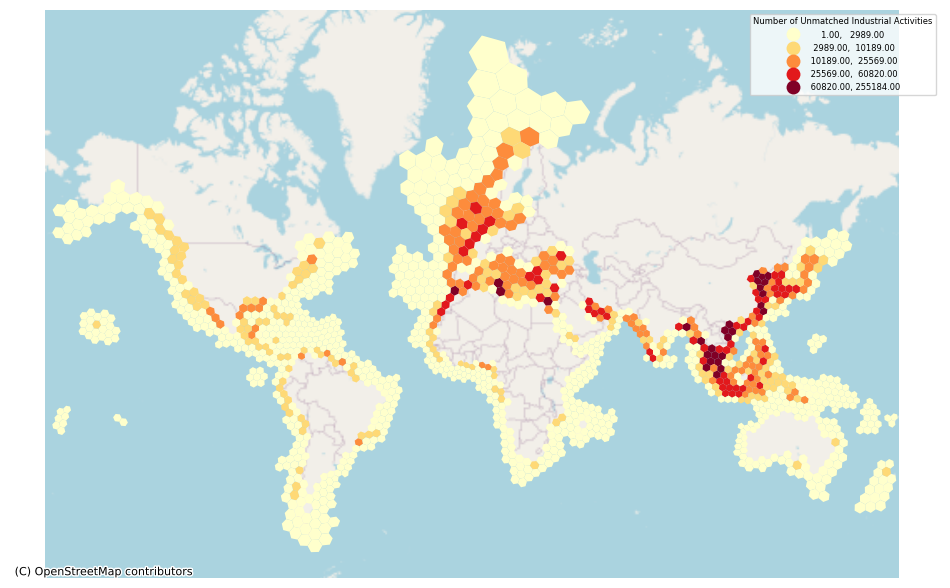

In [32]:
h3_unmatched_gdf = h3_unmatched_gdf.to_crs(epsg=3857)

ax = h3_unmatched_gdf.plot(
    column="num",
    scheme="JenksCaspall",
    cmap="YlOrRd",
    legend=True,
    legend_kwds={"title": "Number of Unmatched Industrial Activities", "fontsize": 6, "title_fontsize": 6},
    figsize=(12,8)
)

cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

### GeoParquet

In [35]:
industrial_vessel_df.repartition(1).write.mode("overwrite"). \
    format("geoparquet"). \
    save(S3_URL_DATA_ROOT + 'globalfishingwatch_industrial_vessels.parquet')

In [34]:
industrial_vessel_df.repartition(1).write.mode("overwrite"). \
    format("geojson"). \
    save(S3_URL_DATA_ROOT + 'globalfishingwatch_industrial_vessels.json')

#### Spatial Filter Performance Comparison

![](https://wherobots.com/wp-content/uploads/2024/01/Screenshot-2024-01-14-at-10.33.35-AM-1024x556.png)

In [36]:
gulf_filter = 'ST_Within(location, ST_GeomFromWKT("POLYGON ((-84.294662 29.840644, -88.952866 30.297018, -89.831772 28.767659, -94.050522 29.61167, -97.038803 27.839076, -97.917709 21.453069, -94.489975 18.479609, -86.843491 21.616579, -80.779037 24.926295, -84.294662 29.840644))"))'

In [37]:
%%time
industrial_vessel_df.where(gulf_filter).count()

CPU times: user 24.3 ms, sys: 8.21 ms, total: 32.5 ms
Wall time: 18.1 s


217508

In [39]:
industrial_vessel_df_pq = sedona.read.format('geoparquet'). \
    load(S3_URL_DATA_ROOT + "globalfishingwatch_industrial_vessels.parquet")

In [40]:
%%time
industrial_vessel_df_pq.where(gulf_filter).count()

CPU times: user 2.92 ms, sys: 4.54 ms, total: 7.46 ms
Wall time: 4.56 s


217508

#### Partitioned GeoParquet

In [43]:
industrial_vessel_df_pq = industrial_vessel_df_pq. \
    withColumn("s2", expr("array_max(ST_S2CellIds(location, 2))"))

industrial_vessel_df_pq.repartition("s2").write.mode("overwrite"). \
    partitionBy("s2"). \
    format("geoparquet"). \
    save(S3_URL_DATA_ROOT + "globalfishingwatch_industrial_vessels_s2part.parquet")


In [44]:
industrial_vessel_df_pq_part_s2 = sedona.read.format("geoparquet"). \
    load(S3_URL_DATA_ROOT + "globalfishingwatch_industrial_vessels_s2part.parquet")

In [47]:
%%time
industrial_vessel_df_pq_part_s2.where(gulf_filter).count()

CPU times: user 0 ns, sys: 4.11 ms, total: 4.11 ms
Wall time: 1.84 s


217508